In [1]:
# We will be implementing Recursive PSO in this notebook
import pickle
import numpy as np
import random

# Loading the database
X = pickle.load(open('input_output.pkl', 'rb'))['x']
print("shape of X:", np.shape(X))

y = pickle.load(open('input_output.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

# A function to return the index of the input in the database
def input_index(Xinput):
  for i, input in enumerate(X):
    if np.array_equal(Xinput, input):
      return y[i]
  return None

shape of X: (25877, 151)
shape of y: (25877,)


In [2]:
def objective_function(x):
    x = np.array(x)

    # Finding the closest data point in the dataset
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    return y[closest_index]

# snap_position essentially snaps the input to the point in the database closest to it
def snap_position(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    snapped_input = X[closest_index]
    return snapped_input

def closest_index(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

class Particle:
    def __init__(self, num_dimensions, lower_bound, upper_bound, init_position, index):
        self.position = init_position
        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = objective_function(self.best_position)
        self.index = index
        self.positions_traversed = [closest_index(init_position)]

class Cluster:
    def __init__(self, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, cluster_index, init_particle_positions, w_particle, c1_particle, c2_particle):
        self.particles = [Particle(num_dimensions, lower_bound, upper_bound, init_particle_positions[ind], ind) for ind in range(num_particles_in_cluster)]

        # Initial Position of the cluster is the average of the positions of all of the particles within that cluster
        init_cluster_position = np.zeros(num_dimensions)
        for particle in self.particles:
            init_cluster_position = np.add(init_cluster_position, particle.position)

        init_cluster_position = (init_cluster_position / num_particles_in_cluster)
        self.position = init_cluster_position

        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = y[closest_index(self.best_position)]

        # To determine the best particle within the cluster:

        self.in_cluster_best_position = self.particles[0].position
        for particle in self.particles:
            if( objective_function(particle.position) > objective_function(self.in_cluster_best_position) ):
                self.in_cluster_best_position = particle.position

        #self.in_cluster_best_position will now have the best particle within the cluster's position
        self.in_cluster_best_fitness = objective_function(self.in_cluster_best_position)

        self.w_particle = w_particle
        self.c1_particle = c1_particle
        self.c2_particle = c2_particle

        self.index = cluster_index

        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        self.positions_traversed = [closest_index(self.position)]

    def update_particles(self):
        for particle in self.particles:
            # Update velocities
            particle.velocity = (self.w_particle * particle.velocity
                                 + self.c1_particle * (particle.best_position - particle.position)
                                 + self.c2_particle * (self.in_cluster_best_position - particle.position))

            if(np.linalg.norm(particle.velocity) > 1.5):
                #print("old norm: ", np.linalg.norm(particle.velocity))
                particle.velocity = ((particle.velocity / np.linalg.norm(particle.velocity)) * 1.5)
                #print("new norm: ", np.linalg.norm(particle.velocity))

            particle.position = particle.position + particle.velocity + self.velocity # We need to move the particles along with the cluster too!

            particle.position = np.clip(particle.position, self.lower_bound, self.upper_bound)
            particle.position = snap_position(particle.position)
            particle.positions_traversed.append(closest_index(particle.position))

    def update_bests_particle(self):
        for particle in self.particles:
            current_fitness = objective_function(particle.position)

            if current_fitness > particle.best_fitness:
                particle.best_position = np.copy(particle.position)
                particle.best_fitness = current_fitness

                if current_fitness > self.in_cluster_best_fitness:
                    self.in_cluster_best_position = np.copy(particle.position)
                    self.in_cluster_best_fitness = current_fitness

    def eliminate_particles(self, num_particles_to_eliminate):
        if not self.particles:
            return []

        for i in range(num_particles_to_eliminate):
            min_index = 0
            for j in range(1, len(self.particles)):
                if ( (objective_function(self.particles[j].position)) < objective_function(self.particles[min_index].position) ):
                    min_index = j
            self.particles.pop(min_index)

    def get_best_particle_fitness(self):
        best_fitness_temp = objective_function(self.particles[0].position)
        for particle in self.particles:
            if ((objective_function(particle.position)) > best_fitness_temp):
                best_fitness_temp = (objective_function(particle.position))

        return best_fitness_temp


class PSO:
    def __init__(self, num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, init_positions):
        self.num_clusters = num_clusters
        self.num_particles_in_cluster = num_particles_in_cluster
        self.num_dimensions = num_dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.w_cluster = w_cluster
        self.c1_cluster = c1_cluster
        self.c2_cluster= c2_cluster
        self.num_iterations = num_iterations
        # def __init__(self, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, cluster_index, init_particle_positions, w_particle, c1_particle, c2_particle):
        self.clusters = [Cluster(num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, ind, init_positions[ind], w_particle, c1_particle, c2_particle) for ind in range(num_clusters)]

        self.global_best_cluster_position = self.clusters[0].position
        self.global_best_cluster_fitness = 0.0

        for cluster in self.clusters:
            if( y[closest_index(cluster.position)] > y[closest_index(self.global_best_cluster_position)] ):
                self.global_best_cluster_position = cluster.position

        self.global_best_cluster_fitness = y[closest_index(self.global_best_cluster_position)]

        self.global_best_position = np.zeros(num_dimensions)
        self.global_best_fitness = 0.0

        self.unique_function_call_ids = []
        self.global_max_for_each_unique_function_call = []

    def update_clusters(self):
        for cluster in self.clusters:

            # Update velocities
            cluster.velocity = (self.w_cluster * cluster.velocity
                                 + self.c1_cluster * np.random.rand() * (cluster.best_position - cluster.position)
                                 + self.c2_cluster * np.random.rand() * (self.global_best_cluster_position - cluster.position))

            if(np.linalg.norm(cluster.velocity) > 1.5):
                cluster.velocity = ((cluster.velocity / np.linalg.norm(cluster.velocity)) * 1.5)

            #print("cluster.velocity: ", cluster.velocity)
            cluster.position = cluster.position + cluster.velocity

            cluster.position = np.clip(cluster.position, self.lower_bound, self.upper_bound)
            cluster.position = snap_position(cluster.position)
            cluster.positions_traversed.append(closest_index(cluster.position))


    # We look at the cluster with the worst perfomring "best particle" and remove that cluster
    def eliminate_clusters(self, num_clusters_to_eliminate):
        if not self.clusters:
            return []

        for i in range(num_clusters_to_eliminate):
            min_index = 0
            for j in range(1, len(self.clusters)):
                if ( (self.clusters[j].get_best_particle_fitness()) < (self.clusters[min_index].get_best_particle_fitness()) ):
                    min_index = j
            self.clusters.pop(min_index)



    def update_bests_cluster(self):
        # Updating each individual cluster's information
        for cluster in self.clusters:
            current_fitness = y[closest_index(cluster.position)]

            if current_fitness > cluster.best_fitness:
                cluster.best_position = np.copy(cluster.position)
                cluster.best_fitness = current_fitness

                if current_fitness > self.global_best_cluster_fitness:
                    self.global_best_cluster_position = np.copy(cluster.position)
                    self.global_best_cluster_fitness = current_fitness


    def update_global_bests(self):
        for cluster in self.clusters:
            if( y[closest_index(cluster.position)] > y[closest_index(self.global_best_position)] ):
                self.global_best_position = cluster.position

            for particle in cluster.particles:
                if( y[closest_index(particle.position)] > y[closest_index(self.global_best_position)] ):
                    self.global_best_position = particle.position

        self.global_best_fitness = y[closest_index(self.global_best_position)]

    def update_unique_function_call_ids(self):
        for cluster in self.clusters:
            if closest_index(cluster.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(cluster.position))

            for particle in cluster.particles:
                if closest_index(particle.position) not in self.unique_function_call_ids:
                    self.unique_function_call_ids.append(closest_index(particle.position))

    def generate_global_max_for_each_unique_function_call(self):
        self.global_max_for_each_unique_function_call.append(y[self.unique_function_call_ids[0]])
        for i in range(1, len(self.unique_function_call_ids)):
            if( y[self.unique_function_call_ids[i]] > self.global_max_for_each_unique_function_call[ (i - 1) ] ):
                self.global_max_for_each_unique_function_call.append(y[self.unique_function_call_ids[i]])
            else:
                self.global_max_for_each_unique_function_call.append(self.global_max_for_each_unique_function_call[ (i - 1) ])


    def optimize(self):
      #for particle in self.particles:
        #   if closest_index(particle.position) not in self.unique_function_call_ids:
        #        self.unique_function_call_ids.append(closest_index(particle.position))
        #    if particle.best_fitness > self.global_best_fitness:
        #        self.global_best_position = np.copy(particle.position)
        #        self.global_best_fitness = particle.best_fitness
        #        self.global_max_for_each_unique_function_call.append(self.global_best_fitness)
        self.update_unique_function_call_ids()
        for i in range(self.num_iterations):

            self.update_clusters()
            self.update_bests_cluster()
            for cluster in self.clusters:
                cluster.update_particles()
                cluster.update_bests_particle()

            self.update_global_bests()
            self.update_unique_function_call_ids()

            # Call the eliminate functions:
            # Firstly, decide to eliminate a cluster or not:
            if ( i != (self.num_iterations - 1) and (i % (self.num_iterations / self.num_clusters) == 0) and i != 0 ):
                print("Cluster Eliminated on iteration ", i)
                self.eliminate_clusters(1)

            if ( i != (self.num_iterations - 1) and (i % self.num_particles_in_cluster == 0) ):
                for cluster in self.clusters:
                    cluster.eliminate_particles(1)


        all_positions_traversed_particles = []
        all_positions_traversed_clusters = []

        for cluster in self.clusters:
            all_positions_traversed_clusters.append(cluster.positions_traversed)
            for particle in cluster.particles:
                all_positions_traversed_particles.append(particle.positions_traversed)

        self.generate_global_max_for_each_unique_function_call()

        return self.global_best_position, self.global_best_fitness, all_positions_traversed_clusters, all_positions_traversed_particles, self.unique_function_call_ids, self.global_max_for_each_unique_function_call


#num_to_eliminate = int((self.num_particles / (self.num_iterations - 1)))



import numpy as np
from sklearn.cluster import KMeans

# This will generate an approximate set of clusters of particles to use in Recursive PSO
def generate_clusters(arrays_list):
    arrays_matrix = np.array(arrays_list) # converting to a matrix so that we can use sklearn.kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0) # Creating a kmeans model
    kmeans.fit(arrays_matrix) # Training our model
    labels = kmeans.labels_ # We will use these labels to generate our clusters
    clusters = {i: [] for i in range(num_clusters)} # initializing our clusters array

    # Iterating through each label and assigning them to our clusters
    for idx, label in enumerate(labels):
        if (len(clusters[label]) < num_particles_in_cluster): # Esnures that we don't add more than num_particles_in_cluster particles to a cluster
            clusters[label].append(arrays_list[idx])

    # And we finally add some dummy particles to each cluster to ensure that each cluster has num_particles_in_cluster particles in them.
    for i in range(num_clusters):
        if (len(clusters[i]) < num_particles_in_cluster):
            for j in range(len(clusters[i]), num_particles_in_cluster):
                clusters[i].append(clusters[i][0])


    print("Cluster sizes: ")
    for j in range(num_clusters):
        print(len(clusters[j]))

    return clusters


num_clusters = 5
num_particles_in_cluster = 10
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w_cluster = 0.5
c1_cluster = 0.5
c2_cluster = 0.5
w_particle = 1.0
c1_particle = 1.0
c2_particle = 1.0
num_iterations = 10

arrays_list = random.choices(X, k=(num_clusters * num_particles_in_cluster))
clusters = generate_clusters(arrays_list)

initial_positions_PSO = []
for clust_index in range(num_clusters):
    initial_positions_PSO.append(clusters[clust_index])

print("Initial Positions: \n", initial_positions_PSO)

# num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, init_positions
pso = PSO(num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions_cluster, all_positions_particle, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions (Cluster): ", all_positions_cluster)
print("All_positions (Particle): ", all_positions_particle)
print("All_function_calls: ", all_function_calls)
print("Global_max_per_function_call: ", global_max_per_function_call)



Cluster sizes: 
10
10
10
10
10
Initial Positions: 
 [[array([1.        , 0.00429219, 0.        , 0.09159628, 0.13394925,
       0.00251418, 0.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.23655914, 0.        , 0.        ,
       0.23655914, 0.23655914, 0.23655914, 0.45      , 0.        ,
       0.        , 0.44554455, 0.45      , 0.45      , 0.20549462,
       0.        , 0.        , 0.20549462, 0.20549462, 0.20549462,
       0.56943967, 0.        , 0.        , 0.56943967, 0.56943967,
       0.56943967, 0.23529412, 0.        , 0.        , 0.23529412,
       0.23529412, 0.23529412, 0.5       , 0.        , 0.        ,
       0.5       , 0.5       , 0.5       , 0.57276995, 0.        ,
       0.        , 0.57276995, 0.57276995, 0.57276995, 0.26332288,
       0.        , 0.        , 0.26332288, 0.26332288, 0.26332288,
       1.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0

Cluster Eliminated on iteration  2
Cluster Eliminated on iteration  4
Cluster Eliminated on iteration  6
Cluster Eliminated on iteration  8
Best position found:  [1.         0.00249918 0.09947745 0.26638027 0.         0.00228776
 0.33333333 0.43335681 0.41934221 0.42741319 0.43642242 0.44529875
 0.32019116 0.40860215 0.36287973 0.58064516 0.17204301 0.17204301
 0.59333333 0.91752577 0.78752437 0.92079208 0.04       0.93
 0.28617446 0.401052   0.35655993 0.54280585 0.14175385 0.14175385
 0.09931708 0.41911373 0.16225751 0.4604869  0.04137317 0.04137317
 0.5751634  0.94117647 0.86419753 0.94117647 0.         0.94117647
 0.51851852 0.5        0.47222222 0.83333333 0.33333333 0.33333333
 0.56807512 0.66666667 0.57589984 1.         0.33333333 0.33333333
 0.45071404 0.74294671 0.64940594 0.74294671 0.         0.74294671
 0.81111111 0.5        0.44444444 1.         0.5        1.
 0.46296296 0.83333333 0.98765432 0.83333333 0.         0.83333333
 0.07777778 0.7        0.27654321 0.7        0. 

[0.347179364, 0.464105753, 0.464105753, 0.464105753, 0.464105753, 0.464105753, 0.577490567, 0.710325301, 4.772120959, 4.772120959, 4.772120959, 4.772120959, 4.772120959, 4.772120959, 4.772120959, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827147, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149, 5.965827149

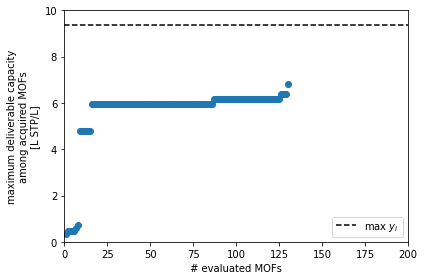

In [4]:
import matplotlib.pyplot as plt

x_values = np.arange(1, len(global_max_per_function_call) + 1)

print(global_max_per_function_call)

plt.figure()
plt.scatter(x_values, global_max_per_function_call)
plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 200])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [5]:
!pip install SciencePlots


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
# now, with this information, we'll try to see how it looks like on a graph, following Visualizations.ipynb
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
from sklearn.decomposition import PCA
import scienceplots

plt.matplotlib.style.use(['science','nature'])
cool_colors = ['#0A84A4', '#F6C95E', '#6F4E7C', '#9DD967', '#CB472E', '#FFA157', '#8CDCD0']

plt.rcParams.update(plt.rcParamsDefault)

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[3], 'RF (div)': cool_colors[5]}

In [8]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

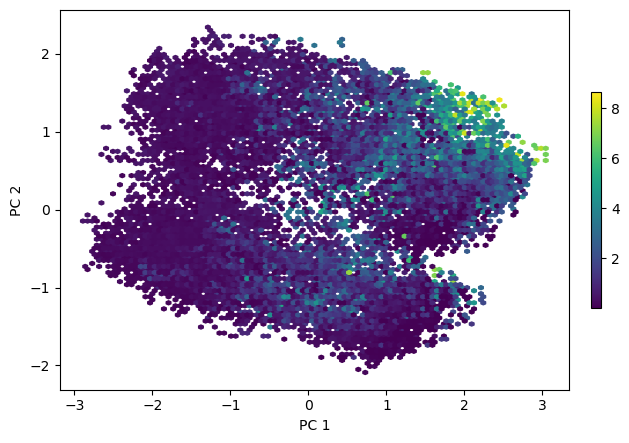

In [9]:
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')
plt.show()

In [10]:
unique_ids = []

for i in range(len(all_positions_cluster)):
    ids_acquired = all_positions_cluster[i]
    for j in all_positions_cluster[i]:
        if j not in unique_ids:
            unique_ids.append(j)

for i in range(len(all_positions_particle)):
    ids_acquired = all_positions_particle[i]
    for j in all_positions_particle[i]:
        if j not in unique_ids:
            unique_ids.append(j)

print(unique_ids)

print("Black Box Function calls: ", len(unique_ids))
print("All_function_calls: ", len(all_function_calls))

[21428, 23231, 17539, 17008, 20123, 17814, 17587, 18487, 19268, 20211, 17225, 18098, 17294, 14140, 17082, 18236, 18128, 20903, 17366, 24014, 12396, 17733, 23794, 17920, 14068, 24208, 22436]
Black Box Function calls:  27
All_function_calls:  130


[[17008, 20123, 17814, 17587, 17587, 17587, 17587, 17587, 18487, 19268, 19268], [20211, 17225, 18098, 17587, 17294, 17587, 17587, 17587, 14140, 18487, 19268], [17082, 18236, 18128, 18128, 18236, 18236, 18236, 18487, 17225, 18487, 19268], [20903, 17366, 17587, 17294, 17587, 17587, 17587, 17587, 14140, 18487, 19268], [24014, 17814, 17294, 17587, 12396, 17587, 17733, 17587, 18487, 18487, 19268], [23794, 17225, 17920, 17587, 17294, 17587, 17587, 14068, 18487, 18487, 19268], [17814, 17814, 17225, 17225, 17587, 17294, 17587, 14068, 18487, 18487, 19268], [24208, 17814, 17225, 17587, 17587, 17587, 17587, 17587, 18487, 18487, 19268], [22436, 17225, 17920, 17587, 17294, 17587, 17587, 17587, 18487, 18487, 19268]]
[17008, 20211, 17082, 20903, 24014, 23794, 17814, 24208, 22436]
[20123, 17225, 18236, 17366, 17814, 17225, 17814, 17814, 17225]
[17814, 18098, 18128, 17587, 17294, 17920, 17225, 17225, 17920]
[17587, 17587, 18128, 17294, 17587, 17587, 17225, 17587, 17587]
[17587, 17294, 18236, 17587, 123

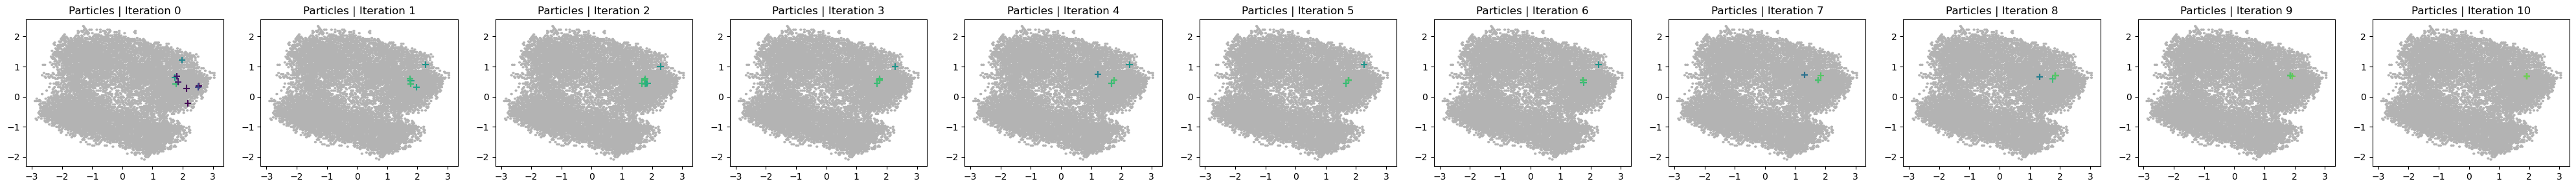

In [11]:
fig, ax = plt.subplots(1, len(all_positions_particle[0]), figsize=(40, 40))
fig.tight_layout()
print(all_positions_particle)


for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(y.shape[0]), cmap="binary", vmin=0, vmax=1)

for i in range(len(all_positions_particle[0])):
    ids_acquired = [id[i] for id in all_positions_particle]
    print(ids_acquired)
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Particles | Iteration {}'.format(i))

#plt.savefig("iterations_!.pdf", bbox_inches="tight")
plt.show()


[[21428, 21428, 21428, 21428, 21428, 21428, 23231, 23231, 17539, 17539, 17539]]
[21428]
[21428]
[21428]
[21428]
[21428]
[21428]
[23231]
[23231]
[17539]
[17539]
[17539]


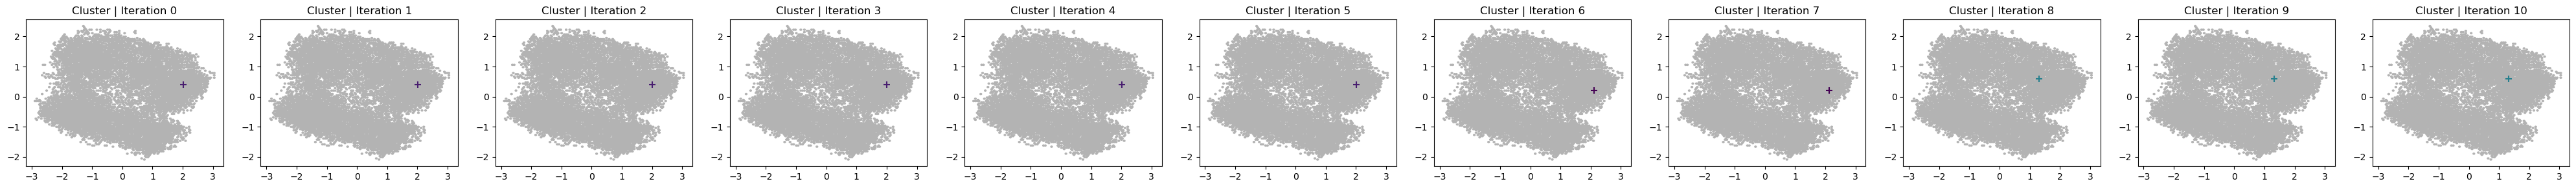

In [12]:
fig, ax = plt.subplots(1, len(all_positions_cluster[0]), figsize=(40, 40))
fig.tight_layout()
print(all_positions_cluster)


for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(y.shape[0]), cmap="binary", vmin=0, vmax=1)

for i in range(len(all_positions_cluster[0])):
    ids_acquired = [id[i] for id in all_positions_cluster]
    print(ids_acquired)
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Cluster | Iteration {}'.format(i))

#plt.savefig("iterations_!.pdf", bbox_inches="tight")
plt.show()


[0.632698521, 0.632698521, 0.729960573, 0.729960573, 0.729960573, 2.787099962, 2.787099962, 2.787099962, 3.912508441, 3.912508441, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.732639267, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303, 4.852217303

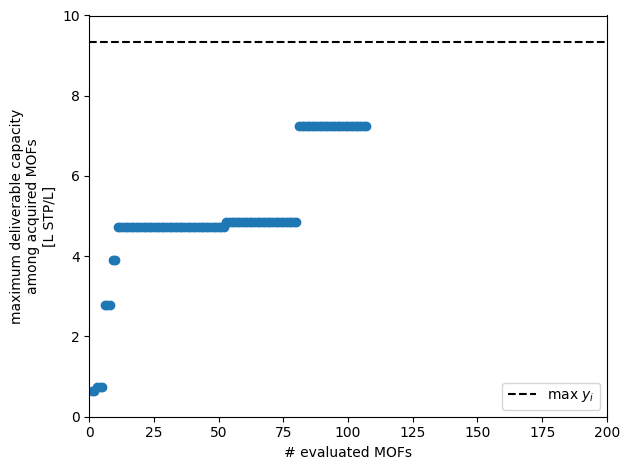

In [ ]:
x_values = np.arange(1, len(global_max_per_function_call) + 1)

print(global_max_per_function_call)

plt.figure()
plt.scatter(x_values, global_max_per_function_call)
plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 200])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [13]:
import time # We want to measure the time it takes to run recEPSO

nb_runs = 50  # Number of runs of this we're doing!
gmpfc_arr = []
apt_arr = []
time_elapsed_per_run = []

for run_no in range(nb_runs):
    print("Run No.: ", run_no)
    
    start_time = time.time()

    # Generating our initial clusters
    arrays_list = random.choices(X, k=(num_clusters * num_particles_in_cluster))
    clusters = generate_clusters(arrays_list)
    initial_positions_PSO = []
    for clust_index in range(num_clusters):
        initial_positions_PSO.append(clusters[clust_index])
    #print("Initial Position for Run No. ", run_no, ": ", initial_positions_PSO)

    # Running Recursive PSO
    pso = PSO(num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, initial_positions_PSO)
    best_position, best_fitness, all_positions_cluster, all_positions_particle, all_function_calls, global_max_per_function_call = pso.optimize()
    
    end_time = time.time()
    elapsed_time = (end_time - start_time)
    print("Run #", run_no, " completed in ", elapsed_time, " seconds!")
    time_elapsed_per_run.append(elapsed_time)
    
    print("best_fitness for Run No. ", run_no, ": ", best_fitness)

    gmpfc_arr.append(global_max_per_function_call)
    apt_arr.append(all_function_calls)

print(gmpfc_arr)
print(apt_arr)
print(time_elapsed_per_run)

# Dumping this data into a .pkl file:
with open('rec_epso_graph_results.pkl', 'wb') as file:
  pickle.dump({'gmpfc_arr': gmpfc_arr, 'apt_arr': apt_arr, 'time_elapsed_per_run': time_elapsed_per_run}, file)

Run No.:  0
Cluster sizes: 
10
10
10
10
10
Cluster Eliminated on iteration  2
Cluster Eliminated on iteration  4
Cluster Eliminated on iteration  6
Cluster Eliminated on iteration  8
Run # 0  completed in  33.781349658966064  seconds!
best_fitness for Run No.  0 :  7.629504192
Run No.:  1
Cluster sizes: 
10
10
10
10
10
Cluster Eliminated on iteration  2
Cluster Eliminated on iteration  4
Cluster Eliminated on iteration  6
Cluster Eliminated on iteration  8
Run # 1  completed in  34.02545881271362  seconds!
best_fitness for Run No.  1 :  7.10652252
Run No.:  2
Cluster sizes: 
10
10
10
10
10
Cluster Eliminated on iteration  2
Cluster Eliminated on iteration  4
Cluster Eliminated on iteration  6
Cluster Eliminated on iteration  8
Run # 2  completed in  33.74083375930786  seconds!
best_fitness for Run No.  2 :  4.879021346
Run No.:  3
Cluster sizes: 
10
10
10
10
10
Cluster Eliminated on iteration  2
Cluster Eliminated on iteration  4
Cluster Eliminated on iteration  6
Cluster Eliminated on

Cluster Eliminated on iteration  6
Cluster Eliminated on iteration  8
Run # 29  completed in  34.046929597854614  seconds!
best_fitness for Run No.  29 :  7.287030743
Run No.:  30
Cluster sizes: 
10
10
10
10
10
Cluster Eliminated on iteration  2
Cluster Eliminated on iteration  4
Cluster Eliminated on iteration  6
Cluster Eliminated on iteration  8
Run # 30  completed in  34.0158576965332  seconds!
best_fitness for Run No.  30 :  4.879021346
Run No.:  31
Cluster sizes: 
10
10
10
10
10
Cluster Eliminated on iteration  2
Cluster Eliminated on iteration  4
Cluster Eliminated on iteration  6
Cluster Eliminated on iteration  8
Run # 31  completed in  34.59985280036926  seconds!
best_fitness for Run No.  31 :  7.367712363
Run No.:  32
Cluster sizes: 
10
10
10
10
10
Cluster Eliminated on iteration  2
Cluster Eliminated on iteration  4
Cluster Eliminated on iteration  6
Cluster Eliminated on iteration  8
Run # 32  completed in  34.44507622718811  seconds!
best_fitness for Run No.  32 :  8.1562

In [ ]:
# Dumping this data into a .pkl file:
with open('rec_epso_graph_results.pkl', 'wb') as file:
  pickle.dump({'gmpfc_arr': gmpfc_arr, 'apt_arr': apt_arr}, file)

In [ ]:
gmpfc_arr = pickle.load(open('rec_epso_graph_results.pkl', 'rb'))['gmpfc_arr']
apt_arr = pickle.load(open('rec_epso_graph_results.pkl', 'rb'))['apt_arr']

In [ ]:
num_iterations_per_run = []
for i in range(len(gmpfc_arr)):
    num_iterations_per_run.append(len(gmpfc_arr[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[112, 152, 132, 112, 110, 118, 117, 131, 130, 95, 128, 123, 127, 98, 123, 114, 98, 139, 120, 97, 131, 112, 109, 103, 135, 115, 106, 112, 119, 119, 128, 98, 103, 118, 103, 143, 117, 96, 133, 119, 108, 113, 123, 126, 106, 127, 117, 128, 103, 121]
152


In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu = []
y_max_sig_bot = []
y_max_sig_top = []

for i in range(max_num_iterations):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes.append(gmpfc_arr[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu.append( np.mean(y_maxes) )
    print("y_max_mu[i]: ", y_max_mu[i])
    print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot.append( np.std ( y_max_sig_bot_temp )  )
    print(y_max_sig_bot[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top.append( np.std ( y_max_sig_top_temp )  )
    print(y_max_sig_top[i])

print("y_max_mu: ", y_max_mu)
print("y_max_sig_bot: ", y_max_sig_bot)
print("y_max_sig_top: ", y_max_sig_top)


y_maxes for iteration  0 :  [0.580633348, 0.562712556, 0.397755769, 0.004978738, 0.01324645, 4.238161134, 2.328297335, 0.399347972, 0.877530443, 0.10021895, 0.503447299, 0.373387175, 0.438348432, 0.375695938, 0.053919228, 0.494244481, 1.247456988, 0.392041331, 4.683779733, 2.228035043, 0.491513572, 0.568701489, 0.56584259, 0.00034451, 0.495273836, 0.554194974, 3.396527628, 0.587475124, 0.641677294, 7.629505071, 0.004978738, 0.449179303, 0.118771083, 0.009340554, 0.003543377, 0.145067205, 4.145266886, 2.030446937, 0.491104793, 0.04317201, 0.710325301, 0.173817268, 0.000372498, 3.585093454, 0.173790198, 0.006426553, 0.127474287, 0.351753764, 0.990369078, 3.512601741]
y_max_mu[i]:  1.0459437891799999
y_maxes < y_max_mu[i]:  [ True  True  True  True  True False False  True  True  True  True  True
  True  True  True  True False  True False False  True  True  True  True
  True  True False  True  True False  True  True  True  True  True  True
 False False  True  True  True  True  True False  

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
np_y_max_mu = np.array(y_max_mu)
np_y_max_sig_bot = np.array(y_max_sig_bot)
np_y_max_sig_top = np.array(y_max_sig_top)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152]


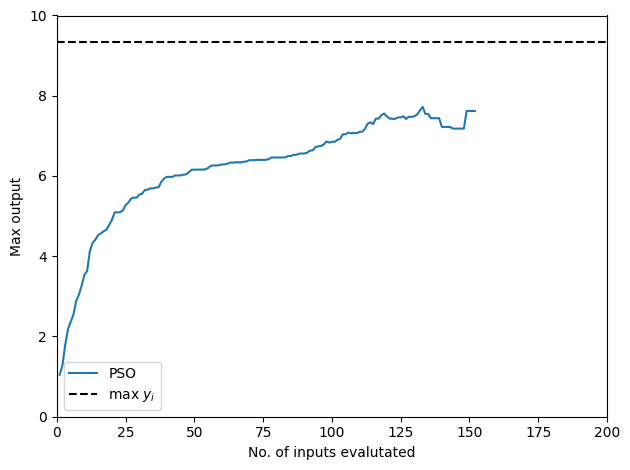

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu - np_y_max_sig_bot, np_y_max_mu + np_y_max_sig_top, alpha=0.2, ec="None")

plt.xlabel('No. of inputs evalutated')
plt.ylabel('Max output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 200])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
#plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
# We're going to "fix" the non-monotonicity of the PSO graph now, by adding dummy samples
gmpfc_arr_fixed = (pickle.load ( open ( 'rec_epso_graph_results.pkl', 'rb' ) ) [ 'gmpfc_arr' ] )
apt_arr_fixed = (pickle.load(open('rec_epso_graph_results.pkl', 'rb'))['apt_arr'])

In [ ]:
num_iterations_per_run = []
for i in range(50):
    num_iterations_per_run.append(len(gmpfc_arr_fixed[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[112, 152, 132, 112, 110, 118, 117, 131, 130, 95, 128, 123, 127, 98, 123, 114, 98, 139, 120, 97, 131, 112, 109, 103, 135, 115, 106, 112, 119, 119, 128, 98, 103, 118, 103, 143, 117, 96, 133, 119, 108, 113, 123, 126, 106, 127, 117, 128, 103, 121]
152


In [ ]:
for i in range(50):
    if (len(gmpfc_arr_fixed[i]) < max_num_iterations):
        for j in range(max_num_iterations - len(gmpfc_arr_fixed[i])):
            gmpfc_arr_fixed[i].append(gmpfc_arr_fixed[i][len(gmpfc_arr_fixed[i]) - 1])


In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu_fixed = []
y_max_sig_bot_fixed = []
y_max_sig_top_fixed = []

for i in range(max_num_iterations):
    y_maxes_fixed = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr_fixed[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes_fixed.append(gmpfc_arr_fixed[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes_fixed)
    y_max_mu_fixed.append( np.mean(y_maxes_fixed) )
    print("y_max_mu_fixed[i]: ", y_max_mu_fixed[i])
    print("y_maxes_fixed < y_max_mu_fixed[i]: ", y_maxes_fixed < y_max_mu_fixed[i])

    y_maxes_L_y_max_mu_i_fixed = y_maxes_fixed < y_max_mu_fixed[i]
    y_max_sig_bot_temp_fixed = []
    for k in range(len(y_maxes_L_y_max_mu_i_fixed)):
        if (y_maxes_L_y_max_mu_i_fixed[k] == True):
            y_max_sig_bot_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_bot_fixed.append( np.std ( y_max_sig_bot_temp_fixed )  )
    print(y_max_sig_bot_fixed[i])

    y_maxes_G_y_max_mu_i_fixed = y_maxes_fixed > y_max_mu_fixed[i]
    y_max_sig_top_temp_fixed = []
    for k in range(len(y_maxes_G_y_max_mu_i_fixed)):
        if (y_maxes_G_y_max_mu_i_fixed[k] == True):
            y_max_sig_top_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_top_fixed.append( np.std ( y_max_sig_top_temp_fixed )  )
    print(y_max_sig_top_fixed[i])

print("y_max_mu_fixed: ", y_max_mu_fixed)
print("y_max_sig_bot_fixed: ", y_max_sig_bot_fixed)
print("y_max_sig_top_fixed: ", y_max_sig_top_fixed)


y_maxes for iteration  0 :  [0.580633348, 0.562712556, 0.397755769, 0.004978738, 0.01324645, 4.238161134, 2.328297335, 0.399347972, 0.877530443, 0.10021895, 0.503447299, 0.373387175, 0.438348432, 0.375695938, 0.053919228, 0.494244481, 1.247456988, 0.392041331, 4.683779733, 2.228035043, 0.491513572, 0.568701489, 0.56584259, 0.00034451, 0.495273836, 0.554194974, 3.396527628, 0.587475124, 0.641677294, 7.629505071, 0.004978738, 0.449179303, 0.118771083, 0.009340554, 0.003543377, 0.145067205, 4.145266886, 2.030446937, 0.491104793, 0.04317201, 0.710325301, 0.173817268, 0.000372498, 3.585093454, 0.173790198, 0.006426553, 0.127474287, 0.351753764, 0.990369078, 3.512601741]
y_max_mu_fixed[i]:  1.0459437891799999
y_maxes_fixed < y_max_mu_fixed[i]:  [ True  True  True  True  True False False  True  True  True  True  True
  True  True  True  True False  True False False  True  True  True  True
  True  True False  True  True False  True  True  True  True  True  True
 False False  True  True  True  

In [ ]:
np_y_max_mu_fixed = np.array(y_max_mu_fixed)
np_y_max_sig_bot_fixed = np.array(y_max_sig_bot_fixed)
np_y_max_sig_top_fixed = np.array(y_max_sig_top_fixed)


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152]


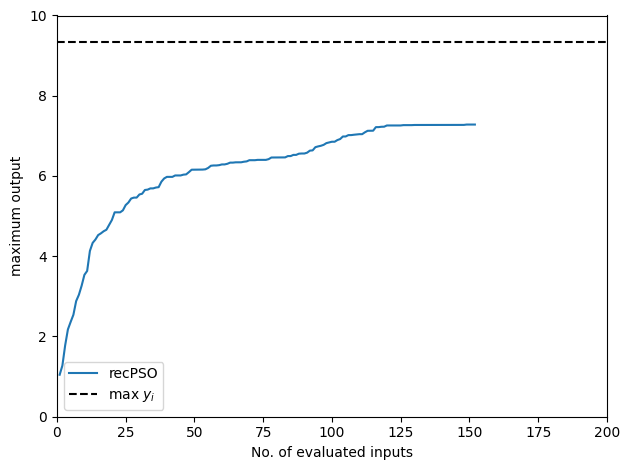

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu_fixed, label="recPSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu_fixed - np_y_max_sig_bot_fixed, np_y_max_mu_fixed + np_y_max_sig_top_fixed, alpha=0.2, ec="None")

plt.xlabel('No. of evaluated inputs')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 200])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
#plt.savefig("search_efficiency_for_specific_acquisition_run_fixed.pdf")
plt.show()

In [ ]:
with open('rec_epso_outputs_fixed.pkl', 'wb') as file:
    pickle.dump({'y_max_mu_fixed_rec_epso': y_max_mu_fixed, 'y_max_sig_bot_fixed_rec_epso': y_max_sig_bot_fixed, 'y_max_sig_top_fixed_rec_epso': y_max_sig_top_fixed}, file)